# Classifying Emotions from Text

In [ ]:
!pip install -q evaluate
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import evaluate
from datasets import Dataset
from sklearn.metrics import confusion_matrix, classification_report


import transformers
from transformers import EarlyStoppingCallback
import evaluate
import torch
import torch.nn as nn
from transformers import AutoTokenizer, BertForSequenceClassification, BertTokenizer
from transformers import TrainingArguments, Trainer
import torch
from tqdm import tqdm

Pull Data

In [ ]:
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
!wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

df1 = pd.read_csv("data/full_dataset/goemotions_1.csv")
df2 = pd.read_csv("data/full_dataset/goemotions_2.csv")
df3 = pd.read_csv("data/full_dataset/goemotions_3.csv")
emotions = pd.concat([df1, df2, df3], ignore_index = True)
emotions.head()

--2025-07-31 13:36:58--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14174600 (14M) [application/octet-stream]
Saving to: ‘data/full_dataset/goemotions_1.csv’

goemotions_1.csv    100%[===================>]  13.52M  41.2MB/s    in 0.3s    

2025-07-31 13:36:58 (41.2 MB/s) - ‘data/full_dataset/goemotions_1.csv’ saved [14174600/14174600]

--2025-07-31 13:36:58--  https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.141.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting respons

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


Dataset shape: (211225, 37)
Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')
                                                text       id  \
0                                    That game hurt.  eew5j0j   
1   >sexuality shouldn’t be a grouping category I...  eemcysk   
2     You do right, if you don't care then fuck 'em!  ed2mah1   
3                                 Man I love reddit.  eeibobj   
4  [NAME] was nowhere near them, he was by the Fa...  eda6yn6   

                author            subreddit    link_id   parent_

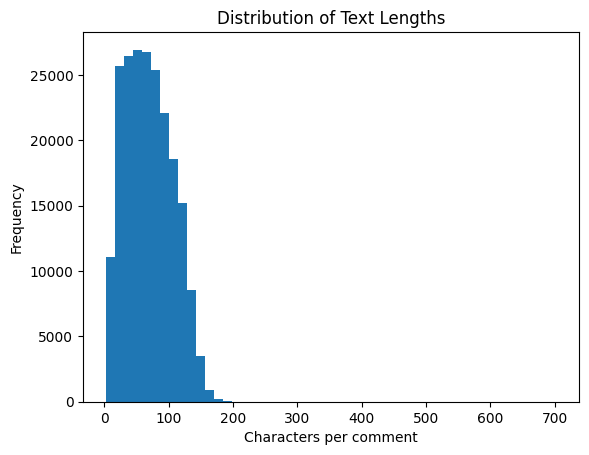

In [ ]:
# Check shape and columns
print(f"Dataset shape: {emotions.shape}")
print(emotions.columns)

# Inspect the first few rows
print(emotions.head())

# Check for missing values
print(emotions.isnull().sum())

# Distribution of text lengths (number of tokens or characters)
emotions['text_length'] = emotions['text'].apply(len)
plt.hist(emotions['text_length'], bins=50)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters per comment")
plt.ylabel("Frequency")
plt.show()

### Data Cleaning
* A text can have more than one row with only one flag for the list of emtion.   
* Making sure we have distinct rows of text where there can be more than one emotion flagged per row
* Removing rows that have no labels

In [ ]:
# Columns to drop
drop_cols = ['id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id','example_very_unclear']

# Find columns that exist in the DataFrame
existing_cols_to_drop = [col for col in drop_cols if col in emotions.columns]

emotions.drop(existing_cols_to_drop, axis = 1, inplace = True)

# shape of data
print("SHAPE BEFORE MULTI-LABELS")
print("Shape of Emotions Dataset", emotions.shape)
print("Number of Unique Texts", emotions[['text','text_length']].nunique())

# Grouping by text and aggregated emtion flags
label_cols = emotions.columns.difference(['text','text_length'])
emotions_multi = emotions.groupby('text')[label_cols].max().reset_index()

print("\nSHAPE AFTER MULTI-LABELS")
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Number of Unique Texts", emotions_multi['text'].nunique())

SHAPE BEFORE MULTI-LABELS
Shape of Emotions Dataset (211225, 30)
Number of Unique Texts text           57732
text_length      192
dtype: int64

SHAPE AFTER MULTI-LABELS
Shape of Emotions Dataset (57732, 29)
Number of Unique Texts 57732


In [ ]:
emotions_multi.head()

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,"""If you don't wear BROWN AND ORANGE...YOU DON...",0,0,1,1,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,"""What do Scottish people look like?"" How I wo...",0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,"### A surprise, to be sure, but a welcome one",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"'*Pray*, v. To ask that the laws of the unive...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,">it'll get invaded by tankie, unfortunately. ...",0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Removing rows that have no labels
emotions_multi = emotions_multi[emotions_multi[label_cols].any(axis=1)]
print("Shape of Emotions Dataset", emotions_multi.shape)

Shape of Emotions Dataset (57730, 29)


### Spliting data into Train, Test, and Validation

* **60% - Train:** Used to train the model and update its weights   
* **20% - Validation:** Used to tune hyperparameters (like learning rate, batch size, epochs) and monitor for overfitting.
* **20% - Test:** Evaluate final model's performance on unseen data after all tuning is done

In [ ]:
# Creating relevant columns for labels
# Y value
label_cols = emotions.columns.difference(['text','text_length'])

# Splitting Train, Test, Validation
x_train, x_temp, y_train, y_temp = train_test_split(emotions_multi['text'], emotions_multi[label_cols], test_size = 0.4, random_state = 42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 42)

# Combine features and labels into one dataframe for each split
train_emotions = pd.concat([x_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
val_emotions   = pd.concat([x_val.reset_index(drop=True),   y_val.reset_index(drop=True)],   axis=1)
test_emotions  = pd.concat([x_test.reset_index(drop=True),  y_test.reset_index(drop=True)],  axis=1)

# Convert the DataFrames into Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_emotions)
val_dataset = Dataset.from_pandas(val_emotions)
test_dataset = Dataset.from_pandas(test_emotions)


## Exploratory Data Analysis

Continuing to use train dataset for data exploration

**Simran Exploration Takeaways:**
* There is some class imbalance when it comes to labels, many text are labeled as neutral. Which makes sense since many text can just be regular comments that don't always need to express emtions.
* Many text have 2 emotions labels

In [ ]:
print("Shape of Emotions Dataset", emotions_multi.shape)
print("Shape of Train Dataset", x_train.shape, y_train.shape)
print("Shape of Test Dataset", x_test.shape, y_test.shape)
print("Shape of Validation Dataset", x_val.shape, y_val.shape)

Shape of Emotions Dataset (57730, 29)
Shape of Train Dataset (34638,) (34638, 28)
Shape of Test Dataset (11546,) (11546, 28)
Shape of Validation Dataset (11546,) (11546, 28)


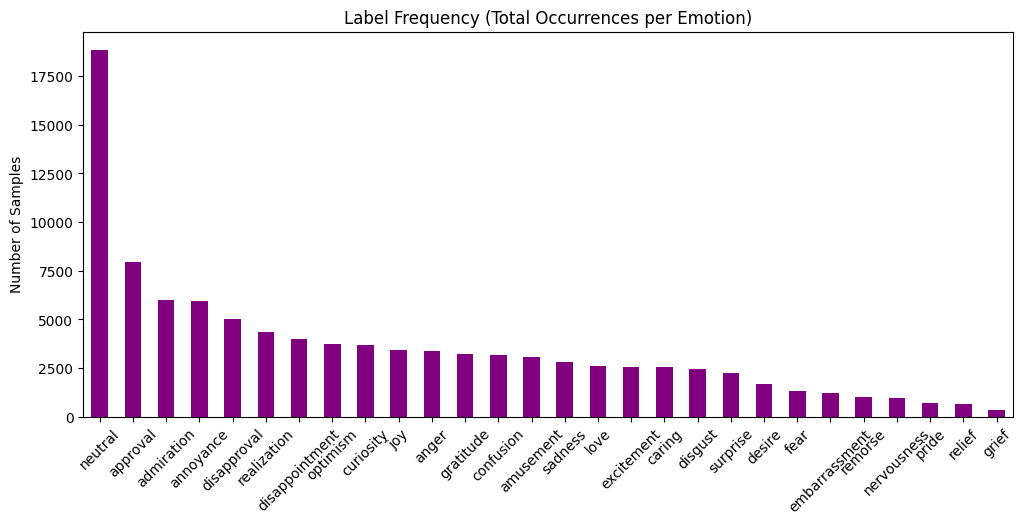

In [ ]:
# Exploring label frequency - seeing which emotions are more common across all text

label_counts = y_train.sum().sort_values(ascending=False)

plt.figure(figsize=(12,5))
label_counts.plot(kind='bar', color='purple')
plt.title("Label Frequency (Total Occurrences per Emotion)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

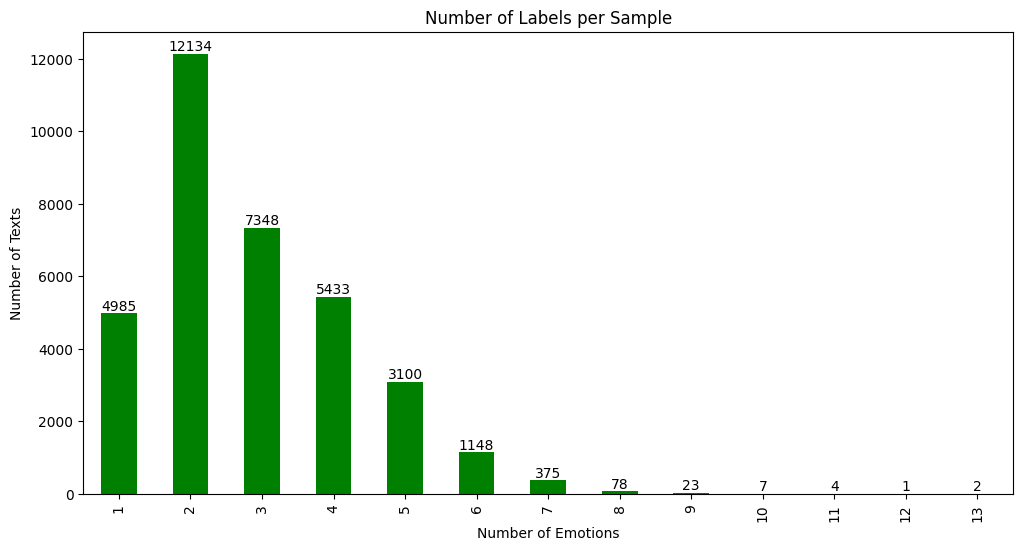

count    34638.000000
mean         2.858854
std          1.413529
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         13.000000
dtype: float64


In [ ]:
# Seeing number of labels a typical text has

num_labels_per_sample = y_train.sum(axis=1)
counts = num_labels_per_sample.value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='green')
for i, count in enumerate(counts):
    plt.text(i, count + 0.05, str(count), ha='center', va='bottom', fontsize=10)
plt.title("Number of Labels per Sample")
plt.xlabel("Number of Emotions")
plt.ylabel("Number of Texts")
plt.show()

print(num_labels_per_sample.describe())


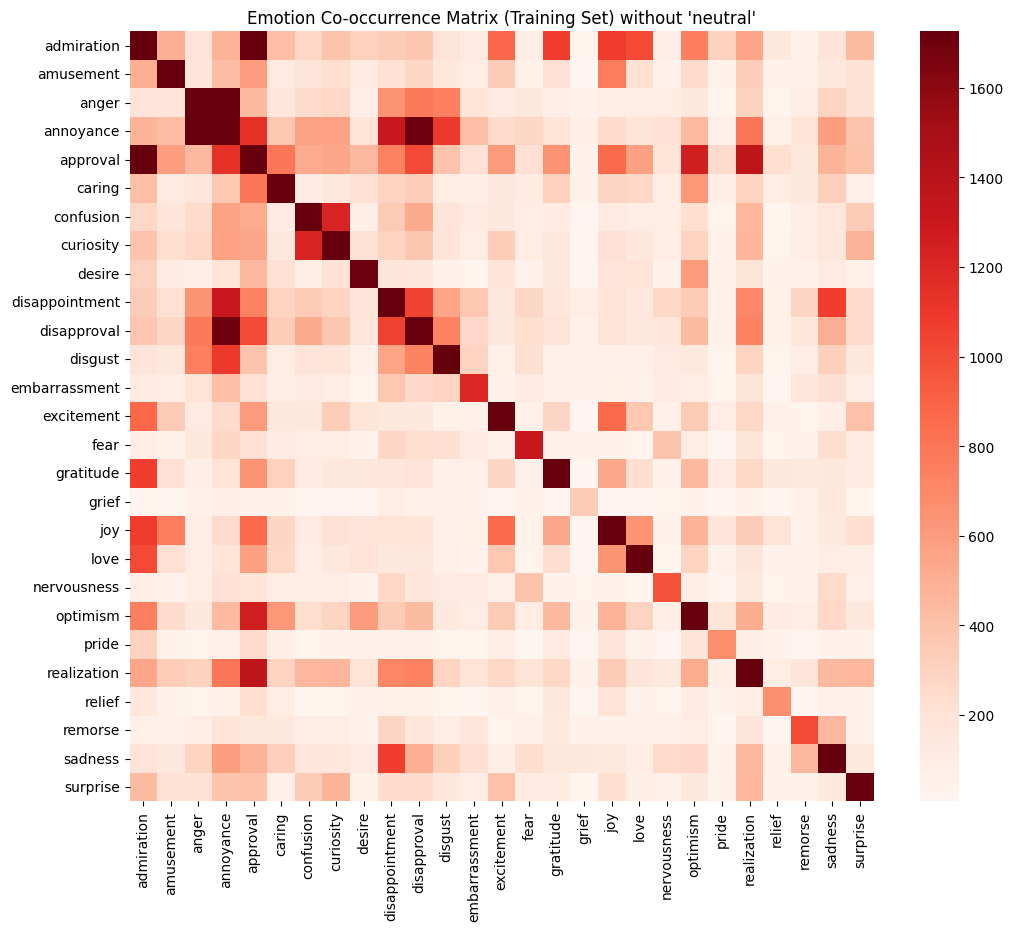

In [ ]:
# emotion co-occurence heatmap, remove "neutral" so it won't dominate the colors

import seaborn as sns

emotions_wo_neutral = y_train.columns.difference(['neutral'])
emotion_cooccur = y_train[emotions_wo_neutral].T.dot(y_train[emotions_wo_neutral])

plt.figure(figsize=(12, 10))
sns.heatmap(emotion_cooccur, cmap="Reds", xticklabels=True, yticklabels=True, vmax=emotion_cooccur.quantile(0.95).max())
plt.title("Emotion Co-occurrence Matrix (Training Set) without 'neutral'")
plt.show()


In [ ]:
# find top co-occurring pairs (excluding neutral)
top_pairs = emotion_cooccur.where(np.triu(np.ones(emotion_cooccur.shape), k=1).astype(bool))
top_pairs = top_pairs.stack().sort_values(ascending=False).reset_index().rename(columns ={'level_0':'emotion_1', 'level_1':'emotion_2',0:'co-orurrence'})

print(top_pairs.head(10))

    emotion_1       emotion_2  co-orurrence
0  admiration        approval        1785.0
1       anger       annoyance        1738.0
2   annoyance     disapproval        1698.0
3    approval     realization        1364.0
4   annoyance  disappointment        1307.0
5    approval        optimism        1260.0
6   confusion       curiosity        1224.0
7   annoyance        approval        1143.0
8   annoyance         disgust        1091.0
9  admiration             joy        1076.0


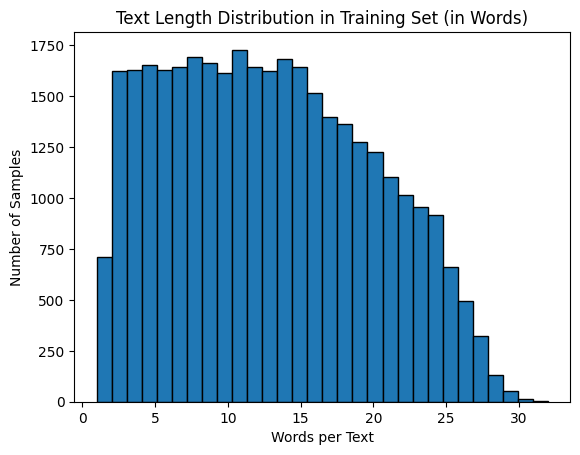

count    34638.000000
mean        12.984006
std          6.698078
min          1.000000
25%          7.000000
50%         13.000000
75%         18.000000
max         32.000000
Name: text, dtype: float64


In [ ]:
# Understaning the size of text inputs

# Calculate number of words per text
x_train_lengths = x_train.str.split().apply(len)

# Plot histogram of text lengths
x_train_lengths.plot(kind='hist', bins=30, edgecolor='black')
plt.title("Text Length Distribution in Training Set (in Words)")
plt.xlabel("Words per Text")
plt.ylabel("Number of Samples")
plt.show()

# Describe text length stats
print(x_train_lengths.describe())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

count    34638.000000
mean        19.350424
std          8.679747
min          3.000000
50%         19.000000
90%         31.000000
95%         34.000000
99%         38.000000
max        316.000000
Name: text, dtype: float64


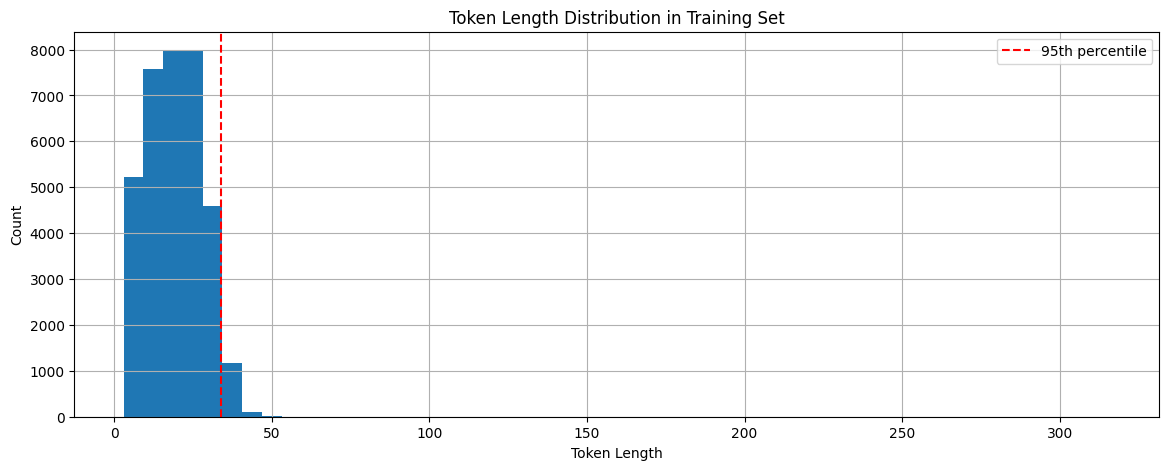

In [ ]:
# token length analysis - help to decide the max sequence length

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
token_lengths = x_train.apply(lambda x: len(tokenizer.encode(x, truncation=False)))

# summary statistics
print(token_lengths.describe(percentiles=[0.9, 0.95, 0.99]))

plt.figure(figsize=(14, 5))
token_lengths.hist(bins=50)
plt.axvline(token_lengths.quantile(0.95), color='red', linestyle='dashed', label='95th percentile')
plt.title("Token Length Distribution in Training Set")
plt.xlabel("Token Length")
plt.ylabel("Count")
plt.legend()
plt.show()

# Testing the 4 different experiments using DistilBERT

| Experiment # | Name                              | Description                                                        |
|--------------|-----------------------------------|--------------------------------------------------------------------|
| 1            | Simple Baseline                   | Creating a simple model without adding weights, thresholds, or freezing layers. |
| 2            | Threshold Only                    | Adding optimal thresholds for each label.                          |
| 3            | Weighted Only                  | Adding class weights to handle imbalance.                             |
| 4            | Weighted + Threshold              | Combines class weights and threshold tuning.                       |
| 5            | Best Model + Freezing Layers | Adds layer freezing to reduce overfitting and improve generalization. |


In [ ]:
MAX_SEQUENCE_LENGTH = 35

In [ ]:
label_cols = emotions.columns.difference(['text','text_length'])  # Skip the 'text' and 'text_length' column

# Preprocessing function that accepts both data and tokenizer
def preprocess_emotions(data, tokenizer):
    """
    Function tokenizes text and converts the emotion labels into a list of floats
    """
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Process multi-label binary targets
    encoded["labels"] = [
        [float(data[label][i]) for label in label_cols]
        for i in range(len(data["text"]))
    ]

    return encoded

###########################################################################
# Compute Metric Baseline
def compute_metrics(p):
    predictions, labels = p
    predictions = (predictions > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    subset_accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='micro')
    recall = recall_score(labels, predictions, average='micro')
    f1 = f1_score(labels, predictions, average='micro')

    # Return all the metrics
    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

###########################################################################

# Function to compute per-epoch metrics for each label
def compute_per_label_metrics(predictions, labels):
    label_metrics = {}
    for idx, label in enumerate(label_cols):
        precision = precision_score(labels[:, idx], predictions[:, idx], zero_division=0)
        recall = recall_score(labels[:, idx], predictions[:, idx], zero_division=0)
        f1 = f1_score(labels[:, idx], predictions[:, idx], zero_division=0)
        label_metrics[label] = {"precision": precision, "recall": recall, "f1": f1}
    return label_metrics


################################################################################

# Compute Metric Fine Tuned
def best_threshold_compute_metrics(p):
    global best_thresholds
    predictions, labels = p

    # Load the best thresholds if they exist
    try:
        best_thresholds = np.load("best_thresholds.npy")
    except FileNotFoundError:
        print("Best thresholds not found. Using default 0.5 thresholds.")
        best_thresholds = None

    # Apply sigmoid if not already applied
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    # Use optimized thresholds if available
    if best_thresholds is not None:
        binary_predictions = np.zeros_like(predictions)
        for i, thresh in enumerate(best_thresholds):
            binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
    else:
        binary_predictions = (predictions >= 0.5).astype(int)

    # Calculate metrics
    subset_accuracy = accuracy_score(labels, binary_predictions)
    precision = precision_score(labels, binary_predictions, average='micro')
    recall = recall_score(labels, binary_predictions, average='micro')
    f1 = f1_score(labels, binary_predictions, average='micro')

    return {
        "subset_accuracy": subset_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


##########################################################################

# Evaluation per Label
def label_evaluation(trainer, preprocessed_dev_data, metrics):

    # Final evaluation on validation set
    final_val_metrics = trainer.evaluate(preprocessed_dev_data)

    print("\nFinal Validation Per-Label Metrics:")
    per_label_metrics = {
        "Label": [],
        "Precision": [],
        "Recall": [],
        "F1": []
    }

    output = trainer.predict(preprocessed_dev_data)
    predictions = output.predictions
    labels = output.label_ids
    predictions = torch.sigmoid(torch.tensor(predictions)).numpy()

    if metrics == compute_metrics:
      binary_predictions = (predictions > 0.5).astype(int)
    else:
      if best_thresholds is not None:
          binary_predictions = np.zeros_like(predictions)
          for i, thresh in enumerate(best_thresholds):
              binary_predictions[:, i] = (predictions[:, i] >= thresh).astype(int)
      else:
          binary_predictions = (predictions >= 0.5).astype(int)

     # Compute metrics per label
    label_metrics = compute_per_label_metrics(binary_predictions, labels)


    for label, metrics in label_metrics.items():
        per_label_metrics["Label"].append(label)
        per_label_metrics["Precision"].append(metrics["precision"])
        per_label_metrics["Recall"].append(metrics["recall"])
        per_label_metrics["F1"].append(metrics["f1"])

    # Create a DataFrame for per-label metrics
    df = pd.DataFrame(per_label_metrics)
    print(df)

    return df


###########################################################################

# Use a wrapper function to pass the tokenizer to the preprocess function
def preprocess_with_tokenizer(batch, tokenizer):
    return preprocess_emotions(batch, tokenizer)

###########################################################################

def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   training_arguments=None,
                                   batch_size=16,
                                   num_epochs=2,
                                   learning_rate = 5e-5,
                                   metrics= compute_metrics):
    """
    Preprocess the data using the given tokenizer.
    Create the training arguments and trainer for the given model and data.
    Then train it.
    """
    # Preprocess the data
    preprocessed_train_data = train_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_with_tokenizer, batched=True, fn_kwargs={'tokenizer': tokenizer})

    # Set the training arguments if not provided
    if training_arguments is None:
        training_args = TrainingArguments(
            output_dir="emotions_model",
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_epochs,
            learning_rate=learning_rate,
            eval_strategy="epoch",
            save_strategy="epoch",
            report_to='none'
        )
    else:
        training_args = training_arguments

    # Set up the trainer
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        tokenizer=tokenizer,
        compute_metrics=metrics
    )

    # Train the model
    trainer.train()

    label_eval = label_evaluation(trainer, preprocessed_dev_data, metrics)


    return trainer, preprocessed_dev_data, label_eval

###########################################################################


def fine_tune_classif_model_freeze_layers(classification_model,
                                          tokenizer,
                                          train_data,
                                          dev_data,
                                          layers_to_train=["classifier."],
                                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                                          batch_size=16,
                                          num_epochs=2,
                                          learning_rate = 5e-5,
                                          metrics=compute_metrics):
    """
    Fine-tune a classification model while freezing all layers except those specified
    in layers_to_train (partial substring match on parameter names).
    """

    # Preprocess the datasets with the tokenizer
    preprocessed_train_data = train_data.map(
        preprocess_with_tokenizer,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )
    preprocessed_dev_data = dev_data.map(
        preprocess_with_tokenizer,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )

    # Freeze all layers except those matching substrings in layers_to_train
    for name, param in classification_model.named_parameters():
      if not any(layer_name in name for layer_name in layers_to_train):
        param.requires_grad = False

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="bert_fine_tuned_freeze_emotions",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        learning_rate=learning_rate,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to='none'
    )

    # Define Trainer
    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        compute_metrics=metrics
    )
    # Train the model
    trainer.train()

    label_eval = label_evaluation(trainer, preprocessed_dev_data, metrics)

    return trainer, preprocessed_dev_data, label_eval

###########################################################################

# create optimal threshold to use for DistilBERT

def calc_label_metrics(label, y_true, y_pred, threshold):
    return {
        "label": label,
        "threshold": threshold,
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

def optimize_thresholds_verbose(predictions, labels, label_names):
    threshold_results = {}
    for t in tqdm(range(5, 100, 5), desc="Optimizing thresholds"):
        threshold = t / 100
        y_preds_all = (predictions > threshold).astype(int)
        threshold_results[threshold] = []
        for label_index, label in enumerate(label_names):
            y_true = labels[:, label_index]
            y_pred = y_preds_all[:, label_index]
            threshold_results[threshold].append(
                calc_label_metrics(label, y_true, y_pred, threshold)
            )

    # Find best threshold per label
    best = {label: {"f1": -1, "result": None} for label in label_names}
    for threshold, results in threshold_results.items():
        for result in results:
            label = result["label"]
            if result["f1"] > best[label]["f1"]:
                best[label] = {
                    "f1": result["f1"],
                    "result": result,
                }

    # Create DataFrame
    results = [b["result"] for b in best.values()]
    df = pd.DataFrame(results, index=[r["label"] for r in results])

    # Save best thresholds for future use
    np.save("best_thresholds.npy", df["threshold"].values)

    return df


## DistilBERT Models

In [ ]:
# Create a DistilBERT class with weights embedded

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertPreTrainedModel


class DistilBERTWeightedClassification(DistilBertPreTrainedModel):
    def __init__(self, config, pos_weight=None):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.distilbert = DistilBertModel(config)
        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        if pos_weight is not None:
            self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            self.loss_fn = nn.BCEWithLogitsLoss()

        # Initialize the model weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(outputs.last_hidden_state[:, 0, :])

        logits = self.classifier(pooled_output)

        if labels is not None:
            loss = self.loss_fn(logits, labels.float())
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

In [ ]:
# calculate weights for the labels

label_freq = y_train.sum() / len(y_train)
pos_weight = (1.0 - label_freq) / label_freq
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32)

##### DistilBERT Baseline **before** Weights and threshold Applied

In [ ]:
# DistilBERT Model - DistilBERT Model before Weights and threshold Applied

from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

distilbert_checkpoint = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_checkpoint)


# Load DistilBERT model
distilbert_base_model = DistilBertForSequenceClassification.from_pretrained(
                                  distilbert_checkpoint,
                                  num_labels=len(label_cols),
                                  problem_type="multi_label_classification"
                                  )


trainer, preprocessed_val_data, distilbert_no_weights_eval = fine_tune_classification_model(
                                                                classification_model=distilbert_base_model,
                                                                tokenizer=distilbert_tokenizer,
                                                                train_data=train_dataset,
                                                                dev_data=val_dataset,
                                                                batch_size=16,
                                                                num_epochs=3
                                                              )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-1180354503.py:187: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.208000,0.202213,0.145505,0.801096,0.315717,0.452931
2,0.188100,0.196914,0.146891,0.777852,0.354547,0.487081
3,0.166800,0.198653,0.150268,0.758885,0.381762,0.507981



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.738971  0.624224  0.676768
1        amusement   0.872010  0.676880  0.762154
2            anger   0.624843  0.437610  0.514729
3        annoyance   0.546798  0.330030  0.411619
4         approval   0.573120  0.312453  0.404423
5           caring   0.583505  0.321591  0.414652
6        confusion   0.581790  0.362500  0.446682
7        curiosity   0.677362  0.638655  0.657439
8           desire   0.684000  0.304813  0.421702
9   disappointment   0.524664  0.266920  0.353831
10     disapproval   0.561860  0.360382  0.439113
11         disgust   0.603306  0.277919  0.380539
12   embarrassment   0.833333  0.115385  0.202703
13      excitement   0.570000  0.261468  0.358491
14            fear   0.707224  0.446043  0.547059
15       gratitude   0.899740  0.665063  0.764804
16           grief   0.400000  0.018182  0.034783
17             joy   0.669725  0.377261  0.482645
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

distilbert_noWeights_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.20043109357357025, 'eval_subset_accuracy': 0.15269357353195911, 'eval_precision': 0.7564729313778743, 'eval_recall': 0.379335391320138, 'eval_f1': 0.5052911652657677, 'eval_runtime': 13.2533, 'eval_samples_per_second': 871.176, 'eval_steps_per_second': 54.477, 'epoch': 3.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.744823  0.622709  0.678314
1        amusement   0.851852  0.676471  0.754098
2            anger   0.598958  0.414041  0.489622
3        annoyance   0.560535  0.347466  0.429001
4         approval   0.565726  0.311954  0.402153
5           caring   0.578000  0.330286  0.420364
6        confusion   0.581871  0.360507  0.445190
7        curiosity   0.713808  0.649657  0.680223
8           desire   0.683019  0.314783  0.430952
9   disappointment   0.496218  0.242424  0.325720
10     disapproval   0.562445  0.378601  0.452565
11         disgust   0.600536  0.267943  0.370554
12   embarrassment   0

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'realization']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['neutral', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['caring', 'neutral']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['approval', 'curiosity', 'neutral']
Actual labels:    ['approval', 'confusion', 'curiosity', 'neutral']


In [ ]:
### try calculating threshold here
predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
predictions = 1 / (1 + np.exp(-logits))
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

threshold_results_df = optimize_thresholds_verbose(predictions, true_labels, label_cols)

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 14.80it/s]


In [ ]:
threshold_results_df

,label,threshold,f1
admiration,admiration,0.35,0.686032
amusement,amusement,0.40,0.769231
anger,anger,0.35,0.552679
annoyance,annoyance,0.25,0.506886
approval,approval,0.25,0.505038
caring,caring,0.25,0.468517
confusion,confusion,0.20,0.531308
curiosity,curiosity,0.30,0.687164
desire,desire,0.30,0.453749
disappointment,disappointment,0.30,0.442807


#### DistilBERT Model **only** Threshold Applied

In [ ]:
# DistilBERT Model - DistilBERT Model without Weights but with Thresholds

distilbert_checkpoint = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_checkpoint)


# Load DistilBERT model
distilbert_onlyTH_model = DistilBertForSequenceClassification.from_pretrained(
                                  distilbert_checkpoint,
                                  num_labels=len(label_cols),
                                  problem_type="multi_label_classification"
                                  )


trainer, preprocessed_val_data, distilbert_onlyTH_eval = fine_tune_classification_model(
                                                                classification_model=distilbert_onlyTH_model,
                                                                tokenizer=distilbert_tokenizer,
                                                                train_data=train_dataset,
                                                                dev_data=val_dataset,
                                                                batch_size=16,
                                                                num_epochs=3,
                                                                metrics=best_threshold_compute_metrics
                                                              )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-1180354503.py:187: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.207800,0.201943,0.092586,0.559967,0.581932,0.570738
2,0.187900,0.196492,0.093972,0.535764,0.630888,0.579448
3,0.166600,0.198225,0.098649,0.539494,0.633016,0.582525



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.674583  0.690994  0.682690
1        amusement   0.839506  0.694522  0.760163
2            anger   0.564706  0.548330  0.556398
3        annoyance   0.426880  0.607532  0.501431
4         approval   0.428571  0.629841  0.510069
5           caring   0.448522  0.500000  0.472864
6        confusion   0.426557  0.698077  0.529540
7        curiosity   0.627660  0.743697  0.680769
8           desire   0.495595  0.401070  0.443350
9   disappointment   0.410714  0.472243  0.439335
10     disapproval   0.442962  0.613962  0.514629
11         disgust   0.398587  0.501269  0.444070
12   embarrassment   0.334286  0.300000  0.316216
13      excitement   0.439024  0.412844  0.425532
14            fear   0.653333  0.470024  0.546722
15       gratitude   0.853318  0.705486  0.772392
16           grief   0.170984  0.300000  0.217822
17             joy   0.562440  0.508183  0.533937
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

distilbert_onlyTH_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.1999567151069641, 'eval_subset_accuracy': 0.09561752988047809, 'eval_precision': 0.5345910330982653, 'eval_recall': 0.6286241752920525, 'eval_f1': 0.5778068320907979, 'eval_runtime': 13.2646, 'eval_samples_per_second': 870.434, 'eval_steps_per_second': 54.43, 'epoch': 3.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.693044  0.700102  0.696555
1        amusement   0.815029  0.691176  0.748011
2            anger   0.515639  0.519352  0.517489
3        annoyance   0.447396  0.632066  0.523935
4         approval   0.422528  0.617837  0.501850
5           caring   0.443907  0.524571  0.480880
6        confusion   0.427861  0.701087  0.531411
7        curiosity   0.656042  0.752475  0.700958
8           desire   0.506550  0.403478  0.449177
9   disappointment   0.388959  0.453067  0.418573
10     disapproval   0.426155  0.607290  0.500848
11         disgust   0.440763  0.525120  0.479258
12   embarrassment   0.

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# get the optimal thresholds
optimal_thresholds = threshold_results_df.set_index("label").loc[label_cols]["threshold"].values

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > optimal_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'approval', 'excitement', 'joy', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['approval', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['caring', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['approval', '

#### DistilBERT Model with Threshold Only and Freezing Layers

In [ ]:
distilbert_checkpoint = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_checkpoint)

distilbert_TH_unfreezed = DistilBertForSequenceClassification.from_pretrained(
                                  distilbert_checkpoint,
                                  num_labels=len(label_cols),
                                  problem_type="multi_label_classification"
                                  )

layers_to_train = ["embeddings.", "layer.4.", "layer.5.","classifier."]


trainer_best, preprocessed_val_data, distilbert_unfreezed_eval= fine_tune_classif_model_freeze_layers(
                                                                      classification_model=distilbert_TH_unfreezed,
                                                                      tokenizer=distilbert_tokenizer,
                                                                      train_data=train_dataset,
                                                                      dev_data=val_dataset,
                                                                      layers_to_train=layers_to_train,
                                                                      batch_size=16,
                                                                      num_epochs=3,
                                                                      metrics = best_threshold_compute_metrics
                                                                    )

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.208600,0.201359,0.092326,0.568399,0.579408,0.573851
2,0.194300,0.196597,0.091114,0.539695,0.623438,0.578552
3,0.182700,0.195685,0.094838,0.546249,0.627056,0.583870



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.686660  0.687371  0.687015
1        amusement   0.849013  0.678737  0.754386
2            anger   0.553522  0.531634  0.542358
3        annoyance   0.433476  0.600595  0.503531
4         approval   0.425750  0.630220  0.508189
5           caring   0.457819  0.505682  0.480562
6        confusion   0.424154  0.699038  0.527959
7        curiosity   0.627342  0.759664  0.687191
8           desire   0.541966  0.402852  0.462168
9   disappointment   0.427319  0.444867  0.435917
10     disapproval   0.440406  0.621718  0.515586
11         disgust   0.409043  0.493655  0.447384
12   embarrassment   0.352941  0.276923  0.310345
13      excitement   0.451128  0.412844  0.431138
14            fear   0.679856  0.453237  0.543885
15       gratitude   0.855781  0.691049  0.764643
16           grief   0.201258  0.290909  0.237918
17             joy   0.558027  0.496985  0.525740
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer_best.evaluate(preprocessed_test_data)
print(test_results)

distilbert_TH_unfreezed_eval_test = label_evaluation(trainer_best, preprocessed_test_data, metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.19809916615486145, 'eval_subset_accuracy': 0.09674346093885328, 'eval_precision': 0.5424948594928033, 'eval_recall': 0.6228133890200351, 'eval_f1': 0.5798861587015329, 'eval_runtime': 13.199, 'eval_samples_per_second': 874.761, 'eval_steps_per_second': 54.701, 'epoch': 3.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.695829  0.696538  0.696183
1        amusement   0.841727  0.688235  0.757282
2            anger   0.506837  0.500450  0.503623
3        annoyance   0.449265  0.625731  0.523014
4         approval   0.417075  0.613662  0.496622
5           caring   0.460963  0.492571  0.476243
6        confusion   0.431730  0.707428  0.536217
7        curiosity   0.647979  0.757045  0.698279
8           desire   0.535211  0.396522  0.455544
9   disappointment   0.394663  0.415373  0.404753
10     disapproval   0.435833  0.614932  0.510119
11         disgust   0.446138  0.525120  0.482418
12   embarrassment   0

In [ ]:
# Predict and inspect outputs
predictions_output = trainer_best.predict(preprocessed_test_data)

# get the optimal thresholds
optimal_thresholds = threshold_results_df.set_index("label").loc[label_cols]["threshold"].values

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > optimal_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'excitement', 'joy', 'realization', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['caring', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Predicted labels: ['approv

#### DistilBERT model **only** Weights Applied

In [ ]:
# DistilBERT Model - DistilBERT with weights

model_checkpoint_name = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_checkpoint)

distilbert_withWeight_model = DistilBERTWeightedClassification.from_pretrained(
                                  distilbert_checkpoint,
                                  num_labels=len(label_cols),
                                  problem_type="multi_label_classification",
                                  pos_weight = pos_weight_tensor
                                  )

trainer, preprocessed_val_data, distilbert_weights_eval= fine_tune_classification_model(
                                                              classification_model=distilbert_withWeight_model,
                                                              tokenizer=distilbert_tokenizer,
                                                              train_data=train_dataset,
                                                              dev_data=val_dataset,
                                                              batch_size=16,
                                                              num_epochs=3
                                        )

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBERTWeightedClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fn.pos_weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-17-1180354503.py:187: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.833300,0.809123,0.042266,0.405822,0.632864,0.494529
2,0.705600,0.804099,0.050147,0.398844,0.646091,0.493216
3,0.584800,0.833874,0.061666,0.423566,0.641074,0.510101



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.525522  0.793996  0.632447
1        amusement   0.511071  0.792943  0.621543
2            anger   0.353543  0.789104  0.488309
3        annoyance   0.373931  0.715064  0.491067
4         approval   0.390712  0.664389  0.492057
5           caring   0.277609  0.728409  0.402007
6        confusion   0.348291  0.813462  0.487749
7        curiosity   0.476462  0.842017  0.608564
8           desire   0.216592  0.693405  0.330081
9   disappointment   0.273810  0.769582  0.403911
10     disapproval   0.355969  0.775656  0.487988
11         disgust   0.253599  0.760152  0.380317
12   embarrassment   0.135165  0.630769  0.222624
13      excitement   0.243827  0.724771  0.364896
14            fear   0.264267  0.721823  0.386889
15       gratitude   0.479979  0.865255  0.617445
16           grief   0.093443  0.518182  0.158333
17             joy   0.323268  0.783807  0.457746
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

distilbert_withWeights_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.8404402732849121, 'eval_subset_accuracy': 0.060020786419539236, 'eval_precision': 0.419048938866012, 'eval_recall': 0.6406089219780885, 'eval_f1': 0.5066663475117887, 'eval_runtime': 13.443, 'eval_samples_per_second': 858.887, 'eval_steps_per_second': 53.708, 'epoch': 3.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.546210  0.803462  0.650319
1        amusement   0.505329  0.790196  0.616444
2            anger   0.319700  0.766877  0.451271
3        annoyance   0.386009  0.747563  0.509127
4         approval   0.384134  0.652372  0.483544
5           caring   0.284037  0.746286  0.411468
6        confusion   0.354191  0.815217  0.493827
7        curiosity   0.505958  0.840823  0.631760
8           desire   0.219901  0.695652  0.334169
9   disappointment   0.270349  0.756098  0.398287
10     disapproval   0.351614  0.787772  0.486212
11         disgust   0.261313  0.766746  0.389784
12   embarrassment   0.

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > 0.5).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'amusement', 'approval', 'confusion', 'excitement', 'gratitude', 'joy', 'love', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'approval', 'gratitude', 'joy', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['admiration', 'curiosity', 'excitement', 'joy', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['anger', 'annoyance', 'caring', 'disappointment', 'disapproval', 'nervousness', 'sadness']
Actual labels:    ['annoyance', 'caring'

In [ ]:
# re-create threshold again for weights + threshold model

predictions_output = trainer.predict(preprocessed_val_data)
logits = predictions_output.predictions
predictions = 1 / (1 + np.exp(-logits))
true_labels = val_dataset.to_pandas()[label_cols.tolist()].values

threshold_results_df = optimize_thresholds_verbose(predictions, true_labels, label_cols)

Optimizing thresholds: 100%|██████████| 19/19 [00:01<00:00, 14.32it/s]


In [ ]:
threshold_results_df

,label,threshold,f1
admiration,admiration,0.75,0.671498
amusement,amusement,0.85,0.757499
anger,anger,0.75,0.545870
annoyance,annoyance,0.60,0.503532
approval,approval,0.50,0.492057
caring,caring,0.80,0.475132
confusion,confusion,0.75,0.533333
curiosity,curiosity,0.80,0.679985
desire,desire,0.90,0.444867
disappointment,disappointment,0.75,0.437184


#### DistilBERT Model - With Weights **and** with Thresholds

In [ ]:
# DistilBERT Model - DistilBERT with weights and Thresholds


distilbert_checkpoint = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_checkpoint)


# Load DistilBERT model
distilbert_withWeights_TH_model = DistilBERTWeightedClassification.from_pretrained(
                                    distilbert_checkpoint,
                                    num_labels=len(label_cols),
                                    problem_type="multi_label_classification",
                                    pos_weight = pos_weight_tensor
                                    )


trainer, preprocessed_val_data, distilbert_withWeightsTH_eval= fine_tune_classification_model(
                                                                      classification_model=distilbert_withWeights_TH_model,
                                                                      tokenizer=distilbert_tokenizer,
                                                                      train_data=train_dataset,
                                                                      dev_data=val_dataset,
                                                                      batch_size=16,
                                                                      num_epochs=3,
                                                                      metrics = best_threshold_compute_metrics
                                                                    )

Some weights of DistilBERTWeightedClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fn.pos_weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-17-1180354503.py:187: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.832300,0.806980,0.064005,0.507164,0.618846,0.557467
2,0.705800,0.800779,0.079768,0.508561,0.640314,0.566883
3,0.588700,0.829962,0.083319,0.516300,0.638550,0.570955



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.692222  0.644928  0.667738
1        amusement   0.830923  0.693593  0.756073
2            anger   0.481686  0.612478  0.539265
3        annoyance   0.417079  0.626858  0.500891
4         approval   0.394689  0.660213  0.494034
5           caring   0.442191  0.495455  0.467310
6        confusion   0.433375  0.669231  0.526077
7        curiosity   0.619679  0.746218  0.677087
8           desire   0.489451  0.413547  0.448309
9   disappointment   0.400742  0.492776  0.442019
10     disapproval   0.419367  0.648568  0.509372
11         disgust   0.369244  0.539340  0.438370
12   embarrassment   0.362776  0.294872  0.325318
13      excitement   0.400381  0.481651  0.437272
14            fear   0.650177  0.441247  0.525714
15       gratitude   0.808324  0.710298  0.756148
16           grief   0.294118  0.272727  0.283019
17             joy   0.515993  0.527993  0.521924
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

distilbert_withWeightsTH_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.8340266942977905, 'eval_subset_accuracy': 0.08124025636584098, 'eval_precision': 0.5110689437065149, 'eval_recall': 0.635796864596574, 'eval_f1': 0.5666504828181474, 'eval_runtime': 13.1973, 'eval_samples_per_second': 874.874, 'eval_steps_per_second': 54.708, 'epoch': 3.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.708379  0.662933  0.684903
1        amusement   0.790698  0.700000  0.742590
2            anger   0.447492  0.602160  0.513431
3        annoyance   0.433463  0.653996  0.521368
4         approval   0.385653  0.650854  0.484326
5           caring   0.446281  0.493714  0.468801
6        confusion   0.439759  0.661232  0.528220
7        curiosity   0.649410  0.754760  0.698133
8           desire   0.463710  0.400000  0.429505
9   disappointment   0.378426  0.479675  0.423077
10     disapproval   0.411177  0.653145  0.504656
11         disgust   0.396624  0.562201  0.465116
12   embarrassment   0.

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# get the optimal thresholds
optimal_thresholds = threshold_results_df.set_index("label").loc[label_cols]["threshold"].values

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > optimal_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'approval', 'excitement', 'joy', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'approval', 'gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['anger', 'annoyance', 'caring', 'neutral']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel,

#### DistilBERT Model with Weights, Thresholds, and Freezing Layers

In [ ]:
distilbert_checkpoint = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained(distilbert_checkpoint)

distilbert_model_unfreezed = DistilBERTWeightedClassification.from_pretrained(
                                  distilbert_checkpoint,
                                  num_labels=len(label_cols),
                                  problem_type="multi_label_classification",
                                  pos_weight = pos_weight_tensor
                                )

layers_to_train = ["layer.3.",
                   "layer.4.",
                   "layer.5."]


trainer, preprocessed_val_data, distilbert_unfreezed_eval= fine_tune_classif_model_freeze_layers(
                                                                      classification_model=distilbert_model_unfreezed,
                                                                      tokenizer=distilbert_tokenizer,
                                                                      train_data=train_dataset,
                                                                      dev_data=val_dataset,
                                                                      layers_to_train=layers_to_train,
                                                                      batch_size=16,
                                                                      num_epochs=3,
                                                                      metrics = best_threshold_compute_metrics
                                                                    )

Some weights of DistilBERTWeightedClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fn.pos_weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/34638 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.847200,0.821901,0.060194,0.505954,0.605893,0.551432
2,0.778800,0.802803,0.074225,0.512043,0.625080,0.562943
3,0.712200,0.796883,0.079508,0.522375,0.624350,0.568828



Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.721814  0.609731  0.661055
1        amusement   0.870192  0.672238  0.758512
2            anger   0.500392  0.561511  0.529193
3        annoyance   0.417219  0.593162  0.489871
4         approval   0.378132  0.693242  0.489347
5           caring   0.456121  0.478409  0.466999
6        confusion   0.432668  0.667308  0.524962
7        curiosity   0.633001  0.747899  0.685670
8           desire   0.525926  0.379679  0.440994
9   disappointment   0.413869  0.431179  0.422346
10     disapproval   0.431789  0.606205  0.504344
11         disgust   0.386940  0.503807  0.437707
12   embarrassment   0.438596  0.256410  0.323625
13      excitement   0.422790  0.455275  0.438432
14            fear   0.673307  0.405276  0.505988
15       gratitude   0.848057  0.692974  0.762712
16           grief   0.313131  0.281818  0.296651
17             joy   0.541199  0.497847  0.518618
18           

In [ ]:
# evaluate the model on the test set
preprocessed_test_data = test_dataset.map(
    preprocess_with_tokenizer,
    batched=True,
    fn_kwargs={'tokenizer': distilbert_tokenizer}
    )

test_results = trainer.evaluate(preprocessed_test_data)
print(test_results)

distilbert_unfreezed_eval_test = label_evaluation(trainer, preprocessed_test_data, metrics=best_threshold_compute_metrics)

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

{'eval_loss': 0.8002842664718628, 'eval_subset_accuracy': 0.07552399099255153, 'eval_precision': 0.5179315044292456, 'eval_recall': 0.6210883118455299, 'eval_f1': 0.5648386430881442, 'eval_runtime': 12.9393, 'eval_samples_per_second': 892.317, 'eval_steps_per_second': 55.799, 'epoch': 3.0}

Final Validation Per-Label Metrics:
             Label  Precision    Recall        F1
0       admiration   0.728108  0.605397  0.661106
1        amusement   0.843596  0.671569  0.747817
2            anger   0.462185  0.544554  0.500000
3        annoyance   0.440834  0.628168  0.518087
4         approval   0.371452  0.690323  0.483006
5           caring   0.465063  0.464000  0.464531
6        confusion   0.445962  0.680254  0.538737
7        curiosity   0.656876  0.749429  0.700107
8           desire   0.531863  0.377391  0.441506
9   disappointment   0.382125  0.401330  0.391492
10     disapproval   0.418043  0.610229  0.496176
11         disgust   0.417293  0.531100  0.467368
12   embarrassment   0

In [ ]:
# Predict and inspect outputs
predictions_output = trainer.predict(preprocessed_test_data)

# get the optimal thresholds
optimal_thresholds = threshold_results_df.set_index("label").loc[label_cols]["threshold"].values

# Apply sigmoid to convert logits to probabilities
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predicted_labels = (probs > optimal_thresholds).astype(int)

# Convert to readable label names
texts = test_dataset["text"]
true_labels = test_dataset.to_pandas()[label_cols.tolist()].values

print("\n Predictions on test data:")
for i in range(5):  # Show 5 samples
    print(f"\nText: {texts[i]}")

    predicted = [label_cols[j] for j in range(len(label_cols)) if predicted_labels[i][j] == 1]
    actual = [label_cols[j] for j in range(len(label_cols)) if true_labels[i][j] == 1]

    print(f"Predicted labels: {predicted}")
    print(f"Actual labels:    {actual}")


 Predictions on test data:

Text: My goodness I didn't even know this existed. This is my first time seeing something like this. Pretty cool stuff.
Predicted labels: ['admiration', 'approval', 'excitement', 'joy', 'realization', 'relief', 'surprise']
Actual labels:    ['admiration', 'excitement', 'surprise']

Text: Thanks for your recommendation! My guy loves board games and those sound like they'd scratch our itches.
Predicted labels: ['admiration', 'gratitude', 'love']
Actual labels:    ['excitement', 'gratitude', 'love']

Text: Oh hey, someone with a brain. Rare round here. 
Predicted labels: ['approval', 'excitement', 'neutral', 'realization', 'surprise']
Actual labels:    ['amusement', 'approval', 'excitement', 'realization']

Text: Stop crying.
Predicted labels: ['caring', 'neutral', 'sadness']
Actual labels:    ['annoyance', 'caring', 'disapproval', 'neutral', 'sadness']

Text: Sure. Let’s start with the terrorists with the biggest guns. How about Israel, or Saudi Arabia? 
Pred

### Creating confusion matrix from best model: Threshold - Only with Freezing

In [ ]:
# Predict
predictions_output = trainer_best.predict(preprocessed_test_data)
logits = predictions_output.predictions
labels = predictions_output.label_ids

# Convert logits to probabilities using sigmoid
probs = torch.sigmoid(torch.tensor(logits)).numpy()

try:
    best_thresholds = np.load("best_thresholds.npy")
    preds = (probs > best_thresholds).astype(int)
except FileNotFoundError:
    print("Best thresholds not found. Using default threshold of 0.5.")
    preds = (probs > 0.5).astype(int)

rows = []
for i in range(preds.shape[1]):
    cm = confusion_matrix(labels[:, i], preds[:, i])
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    rows.append({
        'Label': label_cols[i],
        'True Negative': tn,
        'False Positive': fp,
        'False Negative': fn,
        'True Positive': tp,
        'Precision': round(precision, 3),
        'Recall': round(recall, 3),
        'F1 Score': round(f1, 3)
    })

# Display the final confusion matrix summary
confusion_summary_df = pd.DataFrame(rows)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(confusion_summary_df)

             Label  True Negative  False Positive  False Negative  True Positive  Precision  Recall  F1 Score
0       admiration           8984             598             596           1368      0.696   0.697     0.696
1        amusement          10394             132             318            702      0.842   0.688     0.757
2            anger           9894             541             555            556      0.507   0.500     0.504
3        annoyance           7920            1574             768           1284      0.449   0.626     0.523
4         approval           6651            2260            1018           1617      0.417   0.614     0.497
5           caring          10167             504             444            431      0.461   0.493     0.476
6        confusion           9414            1028             323            781      0.432   0.707     0.536
7        curiosity           9693             540             319            994      0.648   0.757     0.698
8         

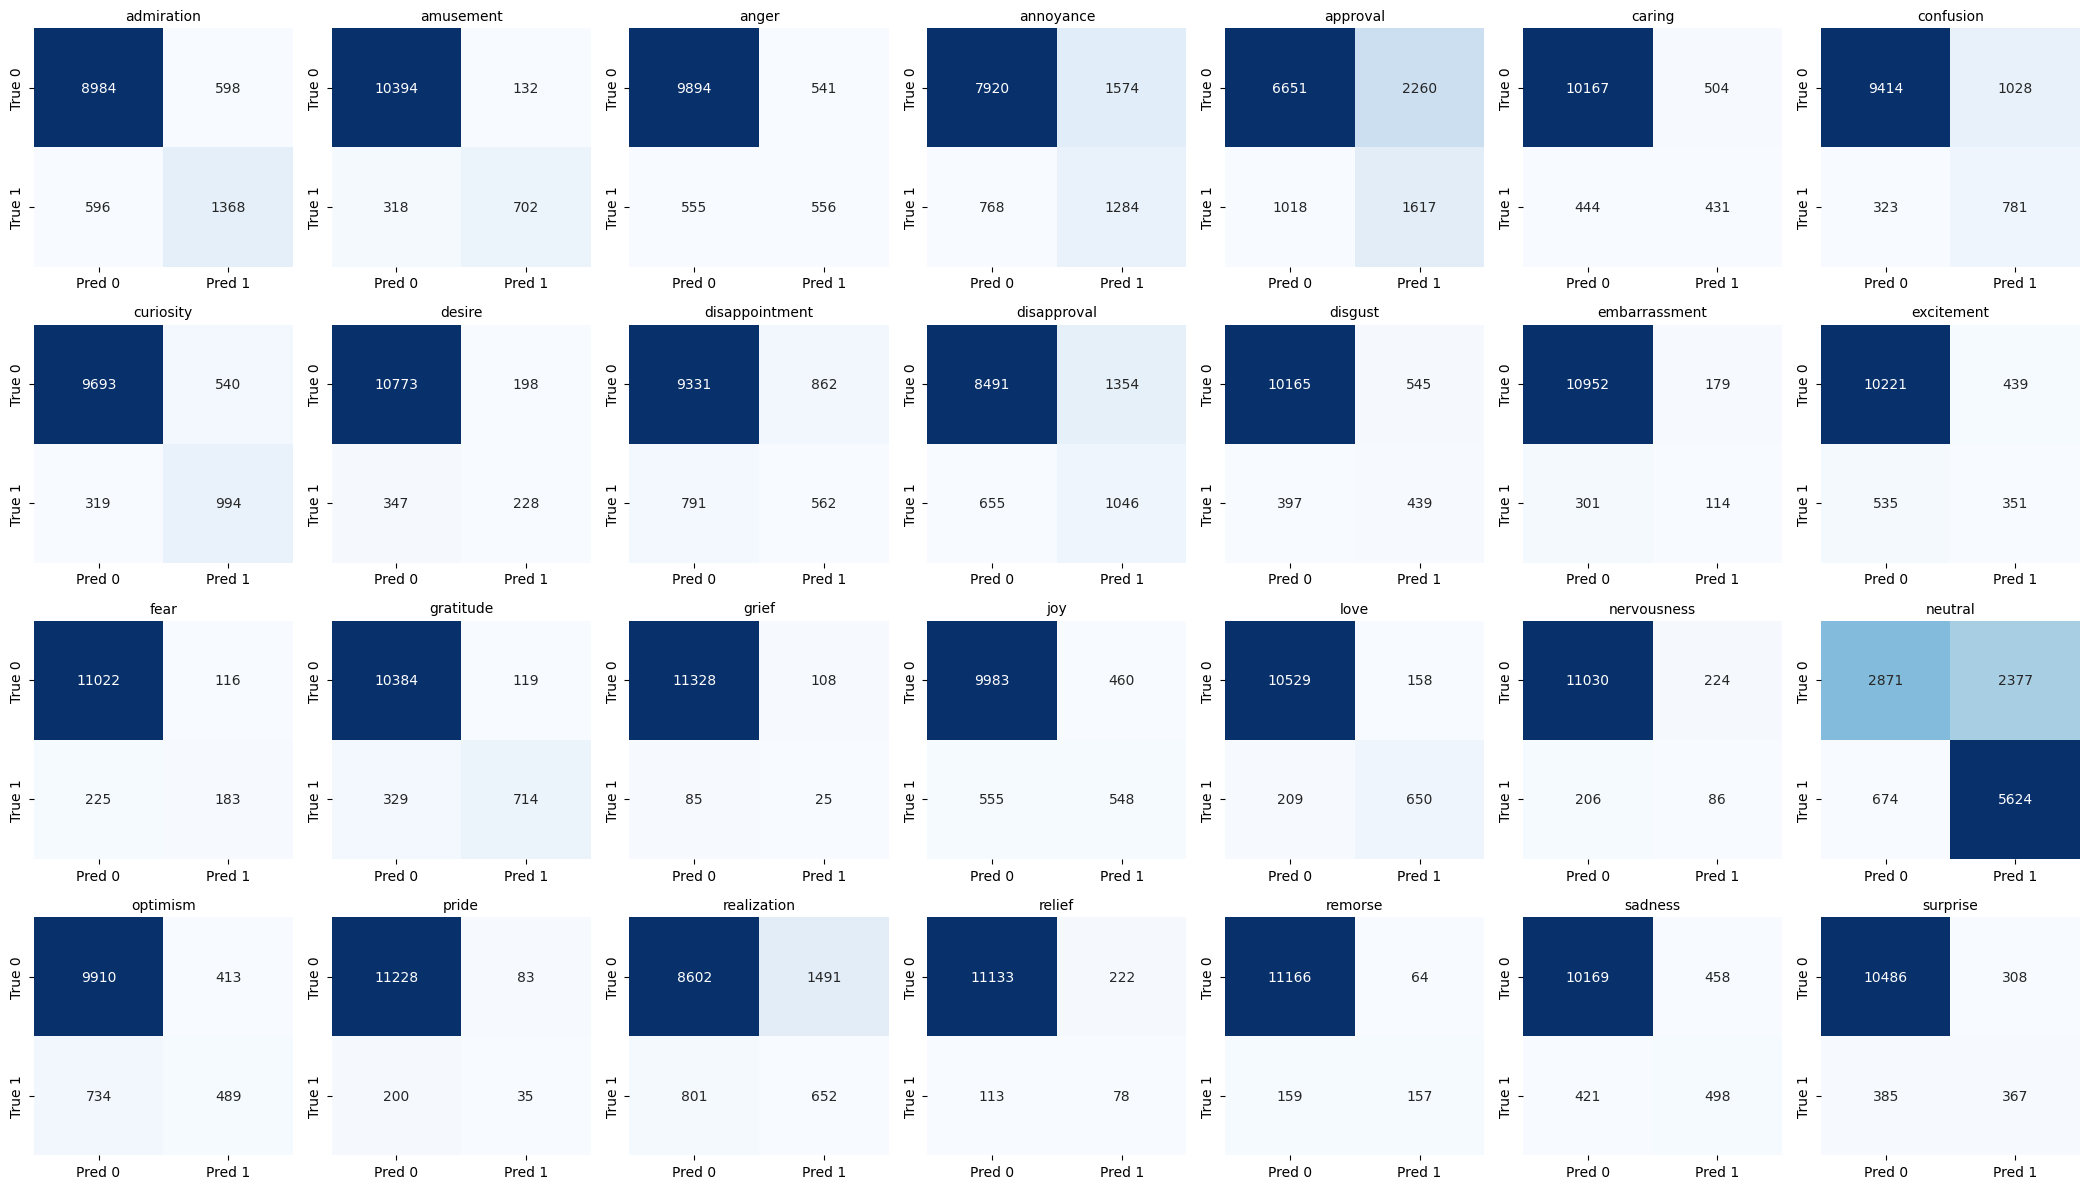

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Set up the grid
rows, cols = 4, 7
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
axes = axes.flatten()

for i in range(len(label_cols)):
    cm = confusion_matrix(labels[:, i], preds[:, i], labels=[0, 1])

    # Handle edge case: only one class present
    if cm.shape != (2, 2):
        full_cm = np.zeros((2, 2), dtype=int)
        full_cm[:cm.shape[0], :cm.shape[1]] = cm
        cm = full_cm

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'], ax=ax)
    ax.set_title(label_cols[i], fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

for j in range(len(label_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

/tmp/ipython-input-2670273058.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='F1 Score', y='Label', palette='viridis')


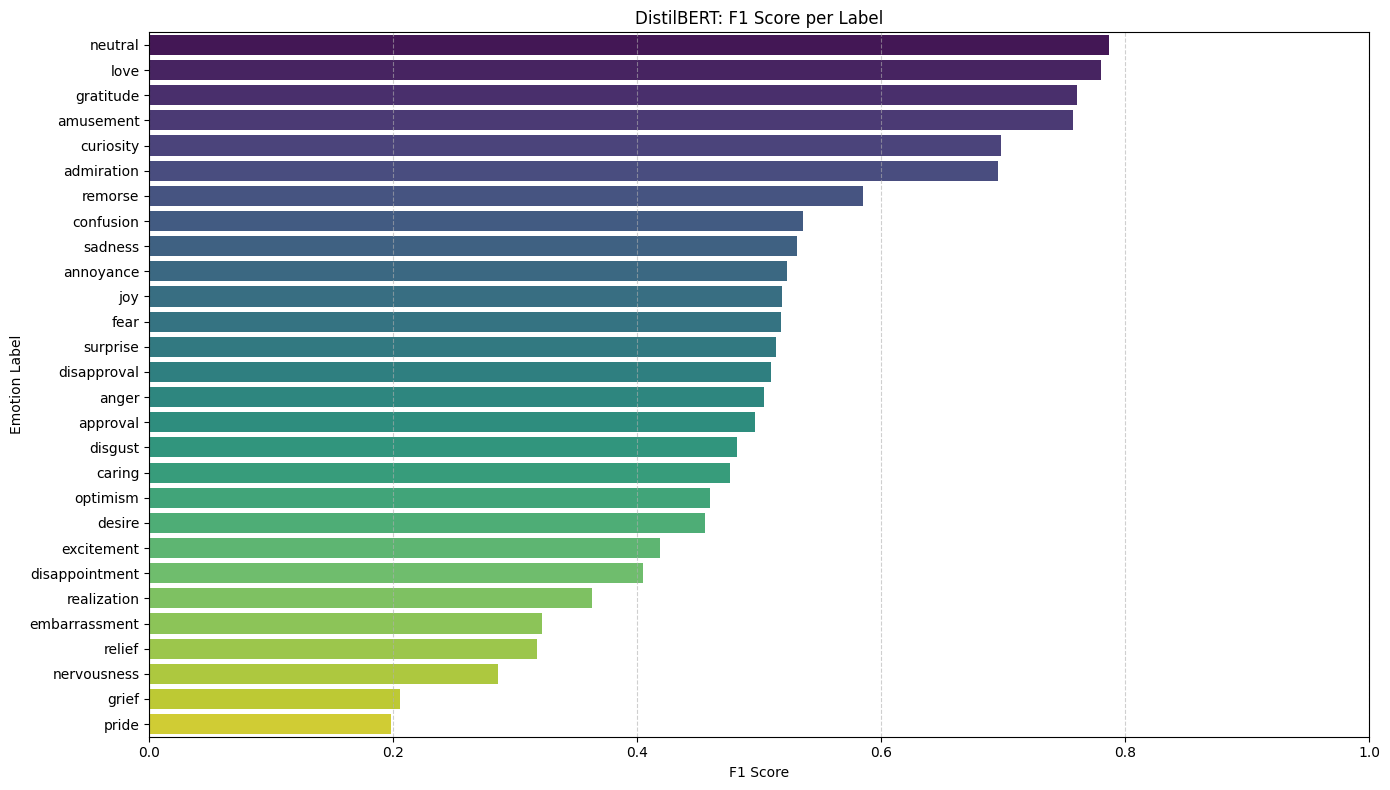

In [ ]:
# Sort by F1 score for better visualization
df_sorted = confusion_summary_df.sort_values(by='F1 Score', ascending=False)

# Set figure size
plt.figure(figsize=(14, 8))

# Plot F1 Score bar chart
sns.barplot(data=df_sorted, x='F1 Score', y='Label', palette='viridis')

plt.title('DistilBERT: F1 Score per Label')
plt.xlabel('F1 Score')
plt.ylabel('Emotion Label')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

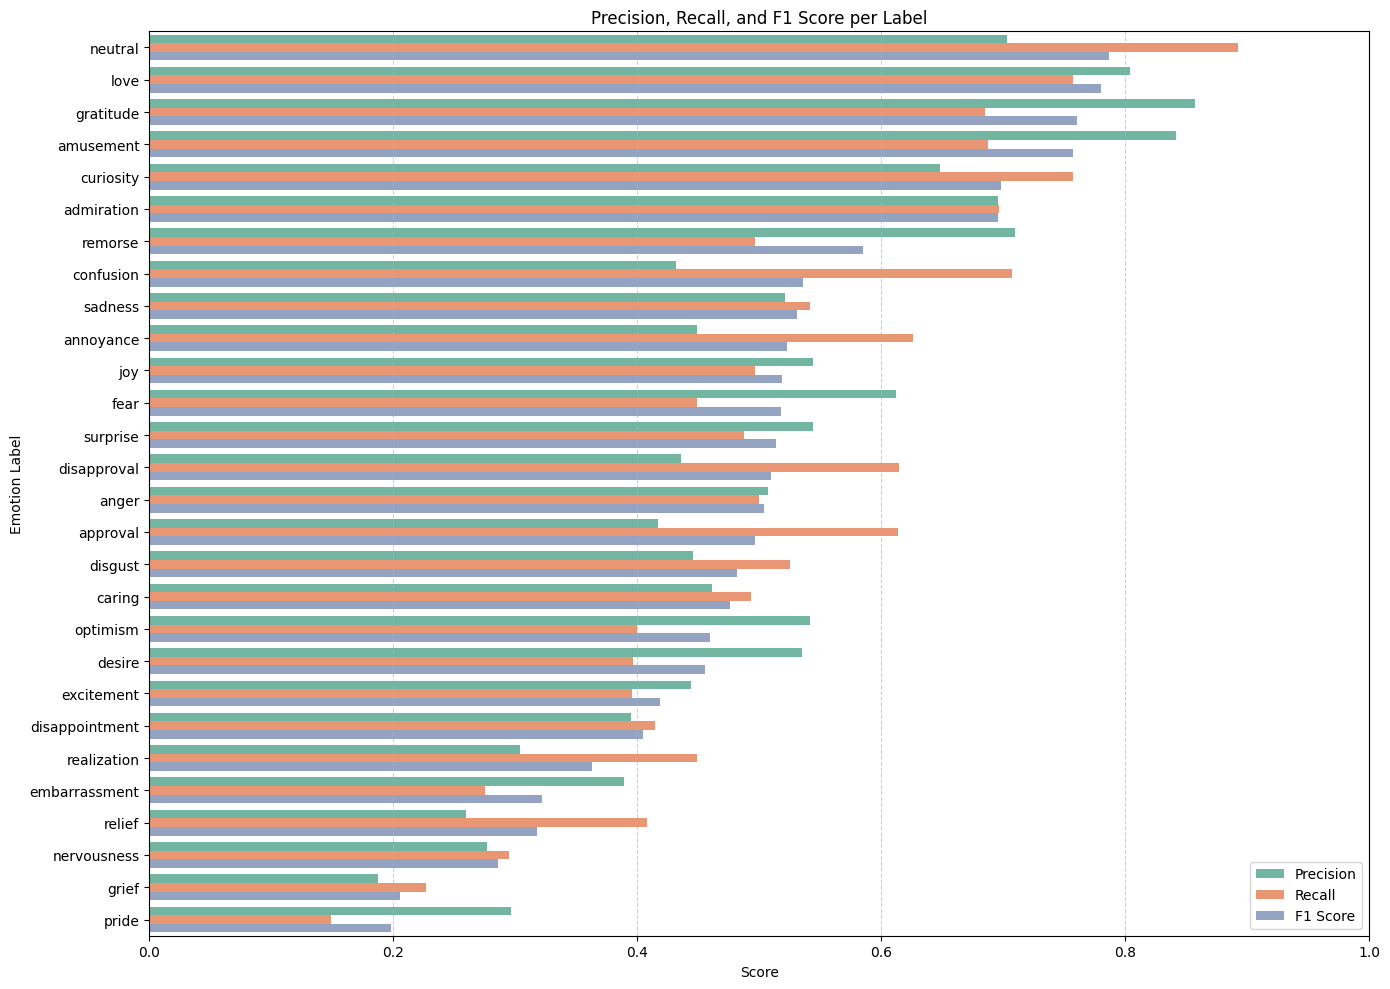

In [ ]:
# Melt the DataFrame to long format for Seaborn
metrics_df = df_sorted[['Label', 'Precision', 'Recall', 'F1 Score']].melt(id_vars='Label',
                                                                          var_name='Metric',
                                                                          value_name='Score')

plt.figure(figsize=(14, 10))
sns.barplot(data=metrics_df, x='Score', y='Label', hue='Metric', palette='Set2')

plt.title('Precision, Recall, and F1 Score per Label')
plt.xlabel('Score')
plt.ylabel('Emotion Label')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

Analyzing per-label precision, recall, and F1 scores in a multi-label emotion classification task provides valuable insights into how well the model is handling each individual emotion. By examining recall specifically, we can identify which emotions the model is frequently missing—these are cases where the emotion is present in the text but not predicted, leading to high false negatives. This is especially important in emotion detection tasks where overlooking subtle or rare emotions like fear or disgust can compromise the utility of the model. Precision, on the other hand, tells us how reliable the model's predictions are for each label—whether it is making accurate predictions without assigning emotions incorrectly. Viewing both metrics side by side helps us understand where the model is confident but possibly overpredicting (high precision, low recall), or where it is too cautious (low precision, high recall). Sorting and visualizing labels by recall allows us to quickly identify which emotions are best captured by the model and which require further attention, guiding efforts in data augmentation, threshold tuning, or model improvement strategies.

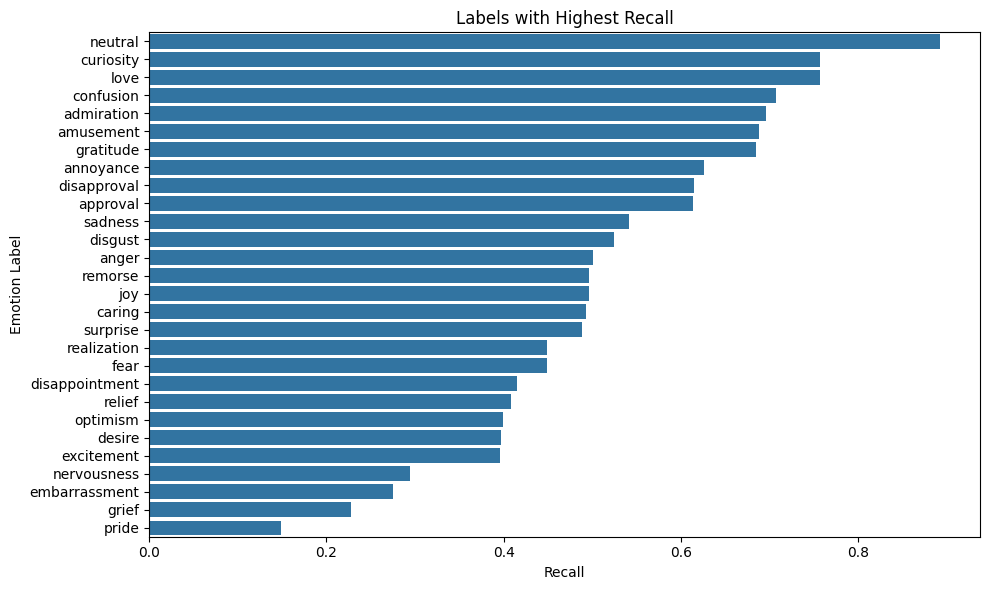

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, and F1 for each label
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None)

# Put into a DataFrame
metric_df = pd.DataFrame({
    'Label': label_cols,
    'Precision': precision,
    'Recall': recall,
    'F1': f1
})

# Sort by Recall
top_recall = metric_df.sort_values(by='Recall', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Recall', y='Label', data=top_recall)
plt.title('Labels with Highest Recall')
plt.xlabel('Recall')
plt.ylabel('Emotion Label')
plt.tight_layout()
plt.show()


This type of visualization is useful in multi-label classification problems because it reveals systematic misclassification patterns—particularly for labels with low recall, such as grief, embarrassment, and pride. In a multi-label setting, a model can predict several emotions per instance, so understanding which labels are predicted instead of a specific true label helps diagnose confusion between emotions. For example, if "grief" is often misclassified as "sadness" or "disappproval," this might indicate semantic overlap or insufficient representation in training data. These insights can guide data augmentation, targeted model improvements, or label grouping strategies to enhance model performance on under-recognized emotions.

/tmp/ipython-input-458134184.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-458134184.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-458134184.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
/tmp/ipython-input-458134184.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecat

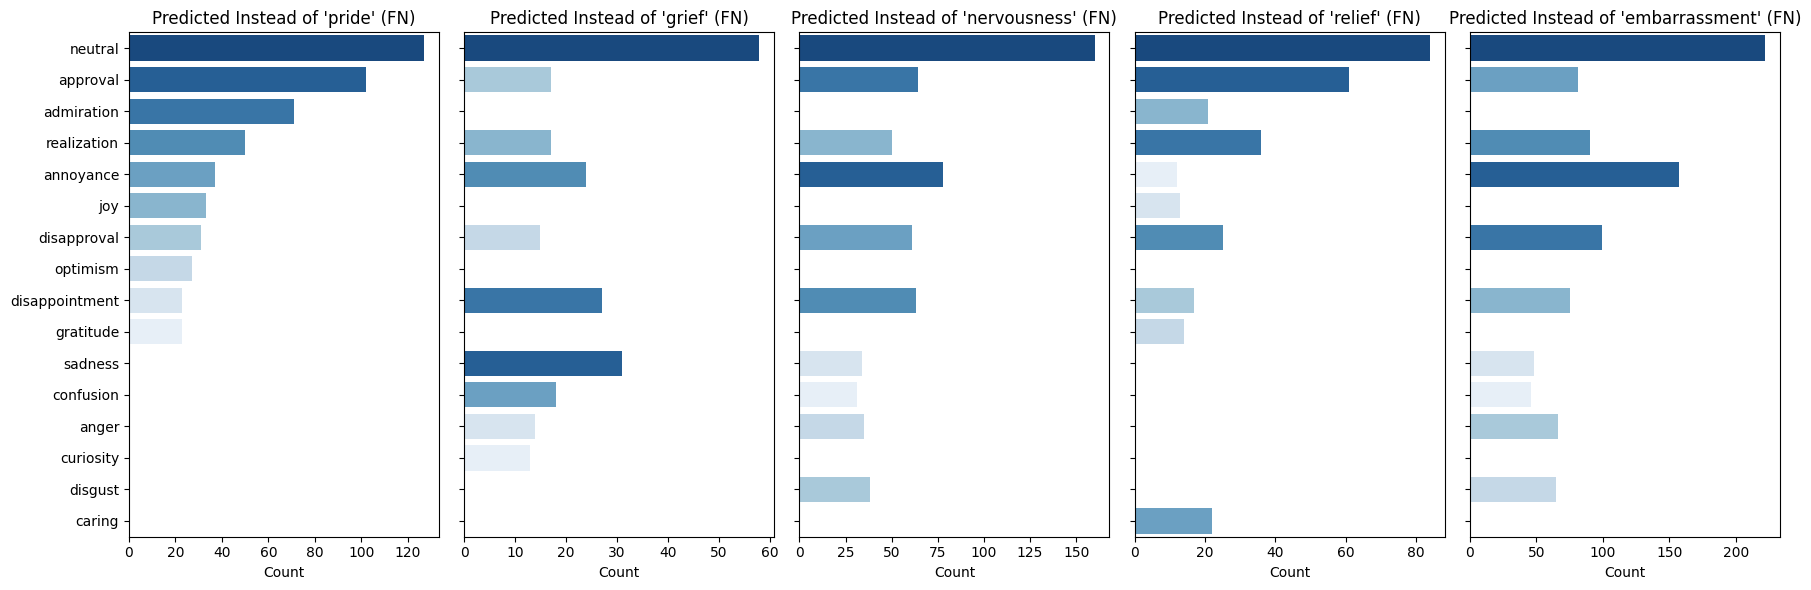

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Labels to analyze
target_labels = [ 'pride','grief','nervousness', 'relief', 'embarrassment']

# Convert to list if it's a Pandas Index
label_cols = list(label_cols)

# Store co-predicted label counts
co_predicted_counts = {}

for target in target_labels:
    idx = label_cols.index(target)

    fn_mask = (labels[:, idx] == 1) & (preds[:, idx] == 0)

    other_preds = preds[fn_mask]

    counts = np.sum(other_preds, axis=0)
    counts[idx] = 0
    co_predicted_counts[target] = pd.Series(counts, index=label_cols)


fig, axes = plt.subplots(1, 5, figsize=(18, 6), sharey=True)

for ax, target in zip(axes, target_labels):
    top_preds = co_predicted_counts[target].sort_values(ascending=False)[:10]

    sns.barplot(x=top_preds.values, y=top_preds.index, ax=ax, palette='Blues_r')
    ax.set_title(f"Predicted Instead of '{target}' (FN)")
    ax.set_xlabel("Count")
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


# New architecture - Training N Binary Models
- Due to the large number of labels, we are selecting the top and bottom 3 labels based on their F1 scores from the best-performing model.

In [ ]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification

## labels of interest

MAX_SEQUENCE_LENGTH = 35

target_labels = ['love', 'gratitude', 'amusement', 'relief', 'pride', 'grief']
distilbert_model_trainer = {}

model_checkpoint_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_checkpoint_name)

################################################################################
# Function to tokenize and extract binary label
def preprocess_binary_label(data, tokenizer, target_label):
    # Tokenize the 'text' data
    encoded = tokenizer.batch_encode_plus(
        data["text"],
        max_length=MAX_SEQUENCE_LENGTH,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=False,
    )

    # Convert the binary label to integer type
    encoded["labels"] = [int(x) for x in data[target_label]]  # Convert to integer for cross_entropy
    return encoded

################################################################################
# Function for computing metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits has shape (batch_size, num_labels)
    preds = logits.argmax(axis=-1)

    return {
        "subset_accuracy": accuracy_score(labels, preds),
        "precision":        precision_score(labels, preds, average='binary', zero_division=0),
        "recall":           recall_score(labels, preds, average='binary', zero_division=0),
        "f1":               f1_score(labels, preds, average='binary', zero_division=0)
    }

################################################################################

# Train binary classifiers
for label in target_labels:

    distilbert_model = DistilBertForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=2, problem_type="single_label_classification")

    train_df = train_dataset.to_pandas()[['text', label]]
    val_df = val_dataset.to_pandas()[['text', label]]

    # Balance the training set (50% positive, 50% negative)
    train_pos = train_df[train_df[label] == 1]
    train_neg = train_df[train_df[label] == 0]

    if len(train_pos) < len(train_neg):
        train_neg = train_neg.sample(n=len(train_pos), random_state=42)
    else:
        train_pos = train_pos.sample(n=len(train_neg), random_state=42)

    train_balanced = pd.concat([train_pos, train_neg]).sample(frac=1, random_state=42)
    train_balanced_dataset = Dataset.from_pandas(train_balanced)
    val_dataset_filtered = Dataset.from_pandas(val_df)

    # Tokenize datasets
    train_encoded = train_balanced_dataset.map(
        lambda x: preprocess_binary_label(x, tokenizer, label), batched=True
    )
    val_encoded = val_dataset_filtered.map(
        lambda x: preprocess_binary_label(x, tokenizer, label), batched=True
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"{label}_emotion_model",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        eval_strategy="epoch",
        save_strategy="epoch",
        report_to="none",
        logging_strategy="epoch"
    )

    # Trainer
    trainer = Trainer(
        model=distilbert_model,
        args=training_args,
        train_dataset=train_encoded,
        eval_dataset=val_encoded,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print(f"\nTraining binary classifier for '{label}'...\n")
    trainer.train()
    distilbert_model_trainer[label] = trainer

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5228 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-20-1808301600.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'love'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.334700,0.227766,0.925515,0.504801,0.842105,0.631218
2,0.205200,0.263205,0.916248,0.470699,0.854691,0.607070


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6412 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-20-1808301600.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'gratitude'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.356500,0.261119,0.897887,0.464539,0.882579,0.608696
2,0.259400,0.285899,0.894682,0.455595,0.873917,0.598945


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6166 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-20-1808301600.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'amusement'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.408300,0.316681,0.923090,0.565489,0.757660,0.647619
2,0.292200,0.373532,0.864369,0.391478,0.818942,0.529730


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1342 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-20-1808301600.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'relief'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.590400,0.591201,0.702148,0.051089,0.820628,0.096189
2,0.363100,0.538099,0.772302,0.064446,0.798206,0.119263


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1362 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-20-1808301600.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'pride'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.668500,0.483687,0.897973,0.067918,0.360190,0.114286
2,0.433600,0.547681,0.754287,0.049726,0.687204,0.092741


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/676 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

/tmp/ipython-input-20-1808301600.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Training binary classifier for 'grief'...



Epoch,Training Loss,Validation Loss,Subset Accuracy,Precision,Recall,F1
1,0.597500,0.632804,0.720249,0.028416,0.854545,0.055003
2,0.319800,0.603703,0.791616,0.035974,0.809091,0.068885


In [ ]:
summary_metrics = []
error_rates = []

for label in target_labels:
    # 1) Tokenize the test split for this label
    test_enc = test_dataset.map(
        lambda x: preprocess_binary_label(x, tokenizer, label),
        batched=True
    )

    # 2) Predict
    logits, label_ids, _ = distilbert_model_trainer[label].predict(test_enc)
    preds = logits.argmax(axis=-1)

    # 3) Performance summary
    acc  = accuracy_score(label_ids, preds)
    prec = precision_score(label_ids, preds, zero_division=0)
    rec  = recall_score(label_ids, preds, zero_division=0)
    f1   = f1_score(label_ids, preds, zero_division=0)

    summary_metrics.append({
        'label':    label,
        'accuracy':  acc,
        'precision': prec,
        'recall':    rec,
        'f1_score':  f1
    })

    # 4) Confusion matrix rates
    tn, fp, fn, tp = confusion_matrix(label_ids, preds).ravel()
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate

    error_rates.append({
        'label':                   label,
        'true_negative_rate':      tnr,
        'false_positive_rate':     fpr,
        'false_negative_rate':     fnr,
        'true_positive_rate':      tpr,
    })

# 5) Build DataFrames
df_summary     = pd.DataFrame(summary_metrics)
df_error_rates = pd.DataFrame(error_rates)

# 6) Display or save
print("=== Performance Summary ===")
print(df_summary.to_string(index=False))
print("\n=== Error Rates ===")
print(df_error_rates.to_string(index=False))

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

Map:   0%|          | 0/11546 [00:00<?, ? examples/s]

=== Performance Summary ===
    label  accuracy  precision   recall  f1_score
     love  0.919020   0.475515 0.859139  0.612194
gratitude  0.896501   0.461382 0.870566  0.603122
amusement  0.867833   0.384369 0.824510  0.524314
   relief  0.780617   0.058113 0.806283  0.108413
    pride  0.753161   0.052379 0.651064  0.096958
    grief  0.790923   0.035109 0.790909  0.067233

=== Error Rates ===
    label  true_negative_rate  false_positive_rate  false_negative_rate  true_positive_rate
     love            0.923833             0.076167             0.140861            0.859139
gratitude            0.899076             0.100924             0.129434            0.870566
amusement            0.872031             0.127969             0.175490            0.824510
   relief            0.780185             0.219815             0.193717            0.806283
    pride            0.755282             0.244718             0.348936            0.651064
    grief            0.790923             0.20907

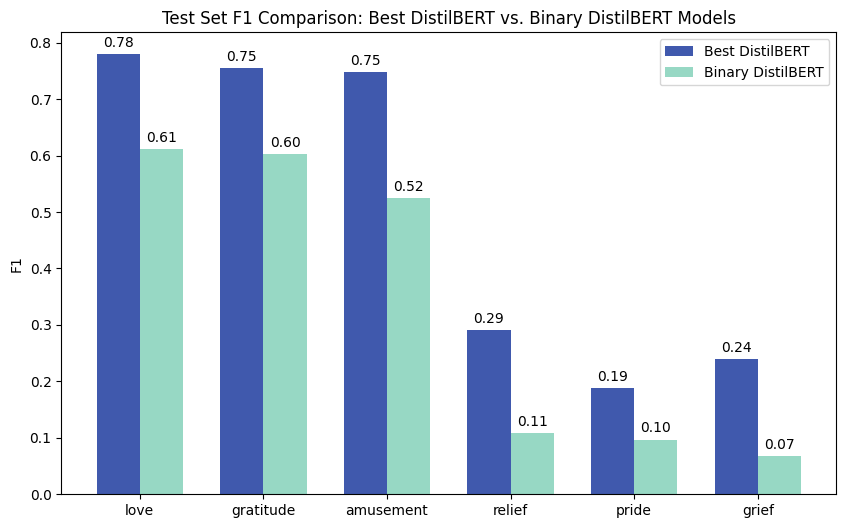

In [3]:
target_labels = ['love', 'gratitude', 'amusement', 'relief', 'pride', 'grief']

# Best distilBERT model F1 results from test set: thresholds only with freezing
distilbert_best_model = [0.779438, 0.754617, 0.748011, 0.290441, 0.188482, 0.239726]

# distilBERT binary results from test set
binary_distilbert = [0.612194, 0.603122, 0.524314, 0.108413, 0.096958, 0.067233]

# creating bar graph
x= np.arange(len(target_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, distilbert_best_model, width, label='Best DistilBERT',color='#4059AD')
rects2 = ax.bar(x + width/2, binary_distilbert, width, label='Binary DistilBERT', color='#97D8C4')

ax.set_ylabel('F1')
ax.set_title('Test Set F1 Comparison: Best DistilBERT vs. Binary DistilBERT Models')
ax.set_xticks(x)
ax.set_xticklabels(target_labels)
ax.legend()

ax.bar_label(rects1, fmt='%.2f', padding=3)
ax.bar_label(rects2, fmt='%.2f', padding=3)

plt.show()
